# Generate Data
Generates all data for use in other scripts. Produces raw data, mfccs, and delta-delta features for mfccs. Make sure to resample all audio with these two scripts first:
* `resampleAudio.m`
* `resampleRun.m`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import scipy

In [2]:
sr = 44100
segment_seconds = 5
segment_length  = sr * segment_seconds
labels   = []
songData = []
adData   = []

In [3]:
# get songs
directory = 'resampled_songs'
numSongs = 0
for filename in os.listdir(directory):
    # Check if the file is a WAV file
    if filename.endswith('.wav'):
        numSongs += 1
        # Construct the full path to the file
        filepath = os.path.join(directory, filename)
        [data, sr_dc] = librosa.load(filepath, sr=sr)
        for i in range(0, len(data), segment_length):
            segment = data[i:i+segment_length]
            if(len(segment) != segment_length):
                #continue #uncomment if end of audio isn't wanted
                segment = np.pad(segment, (0, segment_length - len(segment)), mode='constant')
            labels.append(1)
            songData.append(segment)
print(f"Num Songs is: {numSongs}")

Num Songs is: 13


In [4]:
# get ads
directory = 'resampled_ads'
numAds = 0
for filename in os.listdir(directory):
    # Check if the file is a WAV file
    if filename.endswith('.wav'):
        numAds += 1
        numClips = 0
        # Construct the full path to the file
        filepath = os.path.join(directory, filename)
        [data, sr_dc] = librosa.load(filepath, sr=sr)
        for i in range(0, len(data), segment_length):
            numClips += 1
            segment = data[i:i+segment_length]
            if(len(segment) != segment_length):
                #continue #uncomment if end of audio isn't wanted
                segment = np.pad(segment, (0, segment_length - len(segment)), mode='constant')  
            labels.append(0)
            adData.append(segment)
print(f"Num Ads is: {numAds}")

Num Ads is: 69


In [5]:
# combine data
labels = np.array(labels)
labels = labels.astype(dtype=np.int64)
print(f"label size: {labels.shape}")
print(f"label dtype: {labels.dtype}")
songData = np.array(songData)
songData = songData.astype(dtype=np.float32)
ad_start_index = songData.shape[0]
print(f"song size: {songData.shape}")
adData = np.array(adData)
adData = adData.astype(dtype=np.float32)
print(f"ad size: {adData.shape}")
all_data = np.concatenate((songData, adData), axis=0)
print(f"all_data size: {all_data.shape}")
print(f"all_data dtype: {all_data.dtype}")

label size: (1049,)
label dtype: int64
song size: (563, 220500)
ad size: (486, 220500)
all_data size: (1049, 220500)
all_data dtype: float32


(12, 431)
mfcc_data size: (1049, 431, 12)
mfcc_data dtype: float32


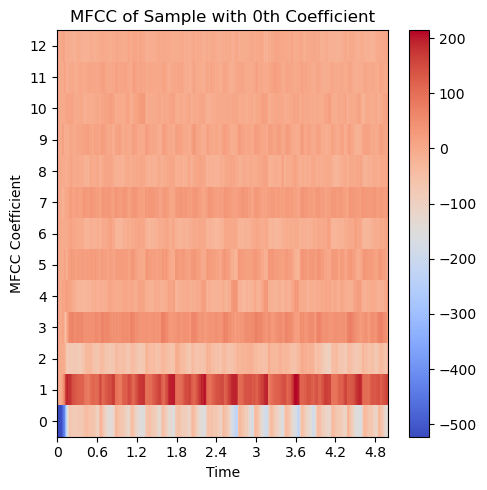

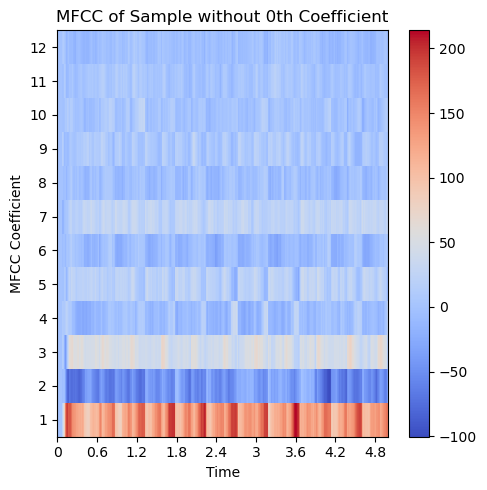

In [6]:
# get mfccs
numCoeffs = 12 # we discard the first coeff
temp_mfcc = librosa.feature.mfcc(y=all_data[0], sr=sr, n_mfcc=(numCoeffs+1))
temp_mfcc = temp_mfcc[1:]
print(temp_mfcc.shape)
mfcc_data = np.empty((all_data.shape[0], temp_mfcc.shape[1], temp_mfcc.shape[0]), dtype=np.float32)
print(f"mfcc_data size: {mfcc_data.shape}")
print(f"mfcc_data dtype: {mfcc_data.dtype}")

for i, value in enumerate(all_data):
    temp_mfcc = librosa.feature.mfcc(y=value, sr=sr, n_mfcc=(numCoeffs+1))
    temp_mfcc = temp_mfcc[1:]
    mfcc_data[i] = temp_mfcc.T

temp_mfcc = librosa.feature.mfcc(y=all_data[0], sr=sr, n_mfcc=(numCoeffs+1))
plt.figure(figsize=(5, 5))
librosa.display.specshow(temp_mfcc, x_axis='time', sr=sr)
plt.yticks(np.arange(0, numCoeffs + 1), np.arange(0, numCoeffs + 1))
plt.ylabel('MFCC Coefficient')
plt.colorbar()
plt.title('MFCC of Sample with 0th Coefficient')
plt.tight_layout()
plt.savefig(os.path.join("graphics", "coeff_0_with.png"), transparent=True)
plt.show()

plt.figure(figsize=(5, 5))
librosa.display.specshow(mfcc_data[0].T, x_axis='time', sr=sr)
plt.yticks(np.arange(0, numCoeffs), np.arange(1, numCoeffs + 1))
plt.ylabel('MFCC Coefficient')
plt.colorbar()
plt.title('MFCC of Sample without 0th Coefficient')
plt.tight_layout()
plt.savefig(os.path.join("graphics", "coeff_0_without.png"), transparent=True)
plt.show()

(12, 431)
(12, 431)
mfcc_delta_data size: (1049, 3, 431, 12)
mfcc_delta_data dtype: float32


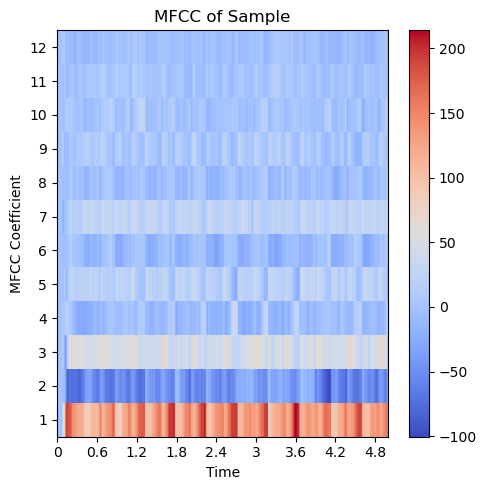

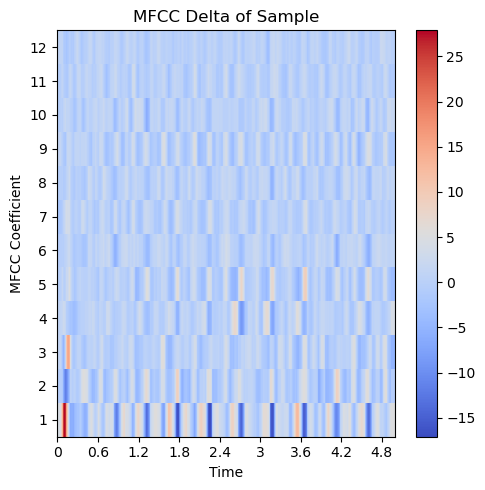

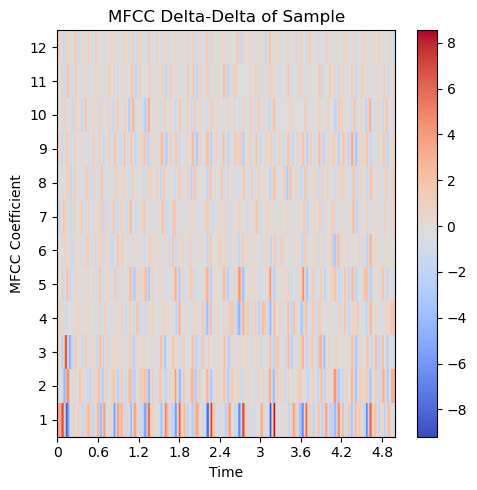

In [7]:
# get delta and delta-delta features
temp_delta = librosa.feature.delta(mfcc_data[0].T)
temp_delta2 = librosa.feature.delta(mfcc_data[0].T, order=2)

print(temp_delta.shape)
print(temp_delta2.shape)

mfcc_delta_data = np.empty((all_data.shape[0], 3, temp_delta.shape[1], temp_delta.shape[0]), dtype=np.float32)
print(f"mfcc_delta_data size: {mfcc_delta_data.shape}")
print(f"mfcc_delta_data dtype: {mfcc_delta_data.dtype}")
for i, value in enumerate(all_data):
    mfcc_delta_data[i][0] = mfcc_data[i]
    mfcc_delta_data[i][1] = librosa.feature.delta(mfcc_data[i].T).T
    mfcc_delta_data[i][2] = librosa.feature.delta(mfcc_data[i].T, order=2).T
    
plt.figure(figsize=(5, 5))
librosa.display.specshow(mfcc_delta_data[0][0].T, x_axis='time', sr=sr)
plt.yticks(np.arange(0, numCoeffs), np.arange(1, numCoeffs + 1))
plt.ylabel('MFCC Coefficient')
plt.colorbar()
plt.title('MFCC of Sample')
plt.tight_layout()
plt.savefig(os.path.join("graphics", "spectro_mfcc.png"), transparent=True)
plt.show()

plt.figure(figsize=(5, 5))
librosa.display.specshow(mfcc_delta_data[0][1].T, x_axis='time', sr=sr)
plt.yticks(np.arange(0, numCoeffs), np.arange(1, numCoeffs + 1))
plt.ylabel('MFCC Coefficient')
plt.colorbar()
plt.title('MFCC Delta of Sample')
plt.tight_layout()
plt.savefig(os.path.join("graphics", "spectro_delta.png"), transparent=True)
plt.show()

plt.figure(figsize=(5, 5))
librosa.display.specshow(mfcc_delta_data[0][2].T, x_axis='time', sr=sr)
plt.yticks(np.arange(0, numCoeffs), np.arange(1, numCoeffs + 1))
plt.ylabel('MFCC Coefficient')
plt.colorbar()
plt.title('MFCC Delta-Delta of Sample')
plt.tight_layout()
plt.savefig(os.path.join("graphics", "spectro_delta_delta.png"), transparent=True)
plt.show()

In [8]:
# write data to np arrays
small_data_size = 100
np.save(os.path.join("data", "labels.npy"), labels)
np.save(os.path.join("data", "mfcc_data.npy"), mfcc_data)
np.save(os.path.join("data", "mfcc_delta_data.npy"), mfcc_delta_data)
np.save(os.path.join("data", "raw_data.npy"), all_data)
np.save(os.path.join("data", "labels_small.npy"), np.concatenate((labels[0:(small_data_size//2)], labels[ad_start_index:(ad_start_index+small_data_size//2)]), axis=0))
np.save(os.path.join("data", "raw_data_small.npy"), np.concatenate((songData[0:(small_data_size//2)], adData[0:(small_data_size//2)]), axis=0))

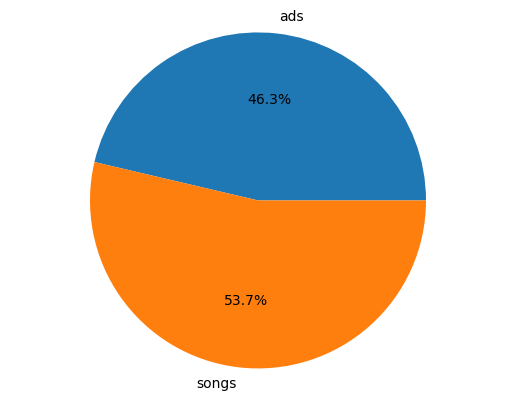

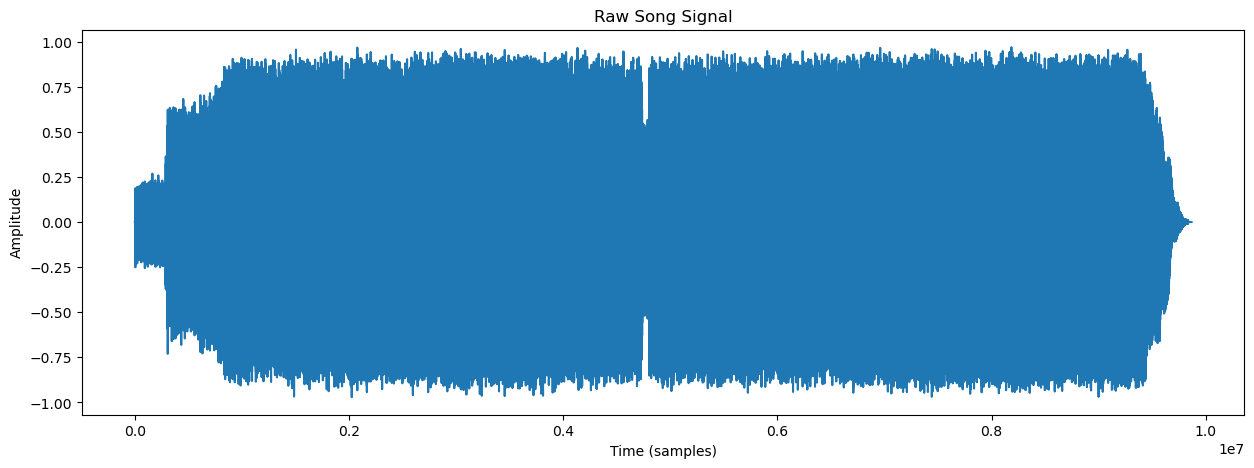

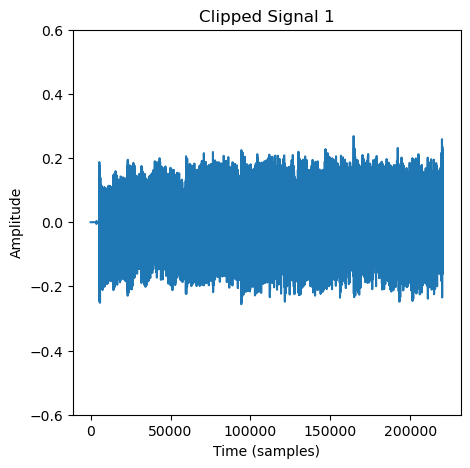

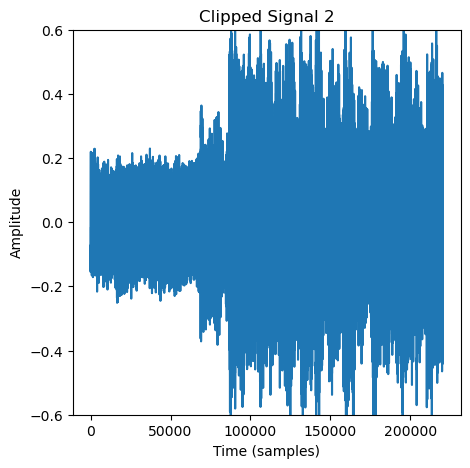

In [9]:
# Generate some extra plots

# Create a pie chart of audio distribution
labels = ['ads', 'songs']
sizes = [adData.shape[0], songData.shape[0] ]  # Values for each section of the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig(os.path.join("graphics", "audio_distribution.png"), transparent=True)
plt.show()
tempData = []
file1 = os.path.join("resampled_songs", "resampled_mr_brightside.wav")

# Generate plots of clipped audio
[data, sr_dc] = librosa.load(file1, sr=sr)
for i in range(0, len(data), segment_length):
    segment = data[i:i+segment_length]
    if(len(segment) != segment_length):
        #continue #uncomment if end of audio isn't wanted
        segment = np.pad(segment, (0, segment_length - len(segment)), mode='constant')
    tempData.append(segment)

plt.figure(figsize=(15, 5))
plt.plot(data)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Raw Song Signal')
plt.savefig(os.path.join("graphics", "audio_raw.png"), transparent=True)
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(tempData[0])
plt.ylim([-0.6, 0.6])
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Clipped Signal 1')
plt.savefig(os.path.join("graphics", "audio_clip_1.png"), transparent=True)
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(tempData[1])
plt.ylim([-0.6, 0.6])
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Clipped Signal 2')
plt.savefig(os.path.join("graphics", "audio_clip_2.png"), transparent=True)
plt.show()

In [10]:
# test normalization
temp_mfcc = librosa.feature.mfcc(y=all_data[0], sr=sr, n_mfcc=(numCoeffs+1))
temp_mfcc = temp_mfcc[1:]
temp_mfcc = temp_mfcc.T
norm = max(all_data[0], key=abs)
print(norm)
data_norm = []
for i, value in enumerate(all_data[0]):
    data_norm.append(value/norm)
print(max(data_norm, key=abs))
data_norm = np.array(data_norm)
temp_mfcc_norm = librosa.feature.mfcc(y=data_norm, sr=sr, n_mfcc=(numCoeffs+1))
temp_mfcc_norm = temp_mfcc_norm[1:]
temp_mfcc_norm = temp_mfcc_norm.T
print(temp_mfcc)
print(temp_mfcc_norm)
diff = []
diff = temp_mfcc - temp_mfcc_norm
print(diff)

0.8746033
1.0
[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 ...
 [159.50433    -59.466766    45.299553   ...  13.375585    -2.0939898
    2.199375  ]
 [176.84312    -54.852257    39.459957   ...  13.298084    -3.0363786
   -0.56533206]
 [158.29381    -32.121532    18.578682   ...   9.120843    -3.4424467
   -6.3486824 ]]
[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 ...
 [159.50433    -59.466755    45.29955    ...  13.375587    -2.0939884
    2.1993766 ]
 [176.84312    -54.85225     39.459953   ...  13.298086    -3.0363789
   -0.56533504]
 [158.29381    -32.12153     18.578678   ...   9.120845    -3.4424496
 